In [1]:
# Loading all the packages we will need
using Catalyst, MomentClosure, OrdinaryDiffEq, DiffEqJump, 
      DiffEqBase.EnsembleAnalysis, Plots, Plots.PlotMeasures

# → for a mass-action rate
# ⇒ for a non mass-action rate 
rn = @reaction_network begin
    (k₁), 0 → x
    (k₂), x → 0
    (k₃*x*y/(x+k₇)), x ⇒ 0
    (k₄*x), 0 ⇒ y₀
    (k₅), y₀ → y
    (k₆), y → 0
end k₁ k₂ k₃ k₄ k₅ k₆ k₇

┌ Info: Precompiling MomentClosure [01a1b25a-ecf0-48c5-ae58-55bfd5393600]
└ @ Base loading.jl:1317


Model ##ReactionSystem#257 with 6 equations
States (3):
  x(t)
  y₀(t)
  y(t)
Parameters (7):
  k₁
  k₂
  k₃
  k₄
  k₅
  k₆
⋮

In [2]:
speciesmap(rn)

Dict{Term{Real, Nothing}, Int64} with 3 entries:
  x(t)  => 1
  y(t)  => 3
  y₀(t) => 2

In [3]:
paramsmap(rn)

Dict{Sym{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 7 entries:
  k₄ => 4
  k₇ => 7
  k₅ => 5
  k₆ => 6
  k₂ => 2
  k₁ => 1
  k₃ => 3

In [4]:
# parameter values [k₁, k₂, k₃, k₄, k₅, k₆, k₇]
p = [90, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01]

# initial molecule numbers of species [x, y₀, y]
u₀ = [70, 30, 60]

# time interval to solve one on
tspan = (0., 200.)

(0.0, 200.0)

In [5]:
jsys = convert(JumpSystem, rn, combinatoric_ratelaws=false)
dprob = DiscreteProblem(jsys, u₀, tspan, p)

jprob = JumpProblem(jsys, dprob, Direct(), save_positions=(false, false))
ensembleprob  = EnsembleProblem(jprob)

@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.2, trajectories=50000);

1332.443829 seconds (2.90 G allocations: 69.838 GiB, 42.81% gc time)


In [6]:
#using JLD2 

#@save "sol_SSA_long_run.jld2" sol_SSA
#@load "sol_SSA_long_run.jld2" sol_SSA

In [7]:
# plot single SSA trajectory
plot(sol_SSA[666], labels=["p53" "pre-Mdm2" "Mdm2"], lw=2, tspan=(0., 100.),
     linecolor=[1 3 2], xlabel="Time [h]", ylabel="Number of molecules", size=(700, 400))

In [8]:
savefig("../docs/src/assets/p53-Mdm2_single_SSA.svg")

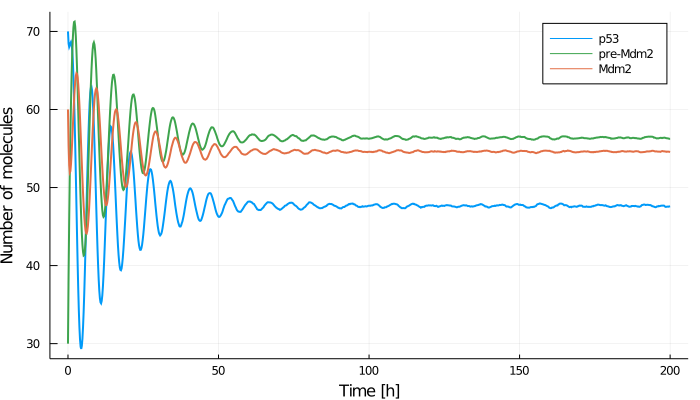

In [9]:
# obtain SSA means and variances
means_SSA, vars_SSA = timeseries_steps_meanvar(sol_SSA)
plot(means_SSA, labels=["p53" "pre-Mdm2" "Mdm2"], lw=2, linecolor=[1 3 2],
     xlabel="Time [h]", ylabel="Number of molecules", size=(700, 400))

In [10]:
savefig("../docs/src/assets/p53-Mdm2_means_SSA.svg")

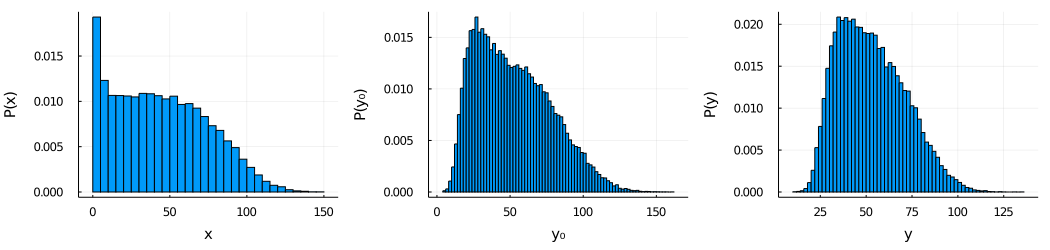

In [11]:
# plot SSA molecule number distributions at t = 25.0
data = componentwise_vectors_timepoint(sol_SSA, 25.0)
h1 = histogram(data[1], normalize=true, xlabel="x", ylabel="P(x)")
h2 = histogram(data[2], normalize=true, xlabel="y₀", ylabel="P(y₀)")
h3 = histogram(data[3], normalize=true, xlabel="y", ylabel="P(y)")

plot(h1, h2, h3, legend=false, layout=(1,3), size = (1050, 250), 
     left_margin = 5mm, bottom_margin = 7mm, guidefontsize=10)

In [12]:
savefig("../docs/src/assets/p53-Mdm2_distribution.svg")

In [13]:
# unload sol_SSA as it's heavy to save ram
sol_SSA = nothing

In [6]:
# second-order moment expansion

closures = ["normal", "log-normal", "gamma"]

# initialise separate plot for each closure
plts = [plot() for i in 1:length(closures)]

for q in 3:6
    println(q)
    eqs = generate_central_moment_eqs(rn, 2, q, combinatoric_ratelaw=false)
    for (closure, plt) in zip(closures, plts)
        println(closure)
        closed_eqs = moment_closure(eqs, closure)

        u₀map = deterministic_IC(u₀, closed_eqs) 
        oprob = ODEProblem(closed_eqs, u₀map, tspan, p)
        
        sol = solve(oprob, Tsit5(), saveat=0.1)
        plt = plot!(plt, sol, vars=(0, 1), lw=2, label  = "q = "*string(q))
    end
end

for plt in plts
    plt = plot!(plt, xlabel = "Time [h]", ylabel = "Mean number of p53 molecules")
    plt = plot!(plt, means_SSA.t, means_SSA[1,:], lw=2, linestyle=:dash, label = "SSA", color="gray")
end

3
normal
log-normal
gamma

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331



4


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331


normal
log-normal
gamma


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331


5
normal
log-normal
gamma


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331


6


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331


normal
log-normal
gamma

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\chemegrad2018\.julia\packages\SciMLBase\oTP8b\src\integrator_interface.jl:331


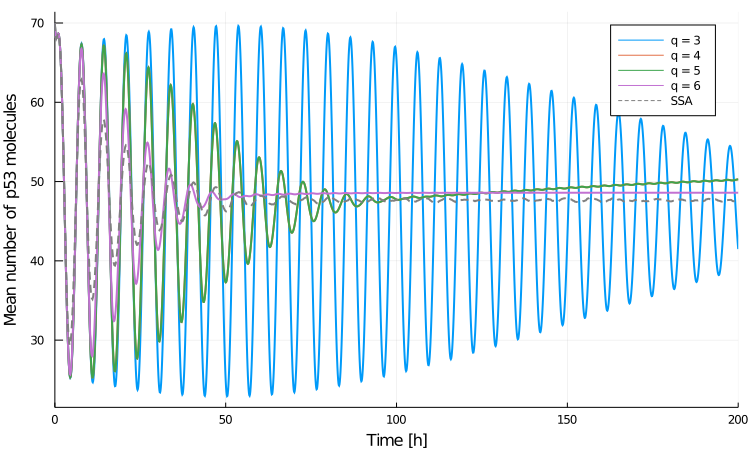

In [15]:
# normal closure
plot(plts[1], size=(750, 450), leftmargin=2mm)

In [16]:
savefig("../docs/src/assets/p53-Mdm2_normal_2nd_order.svg")

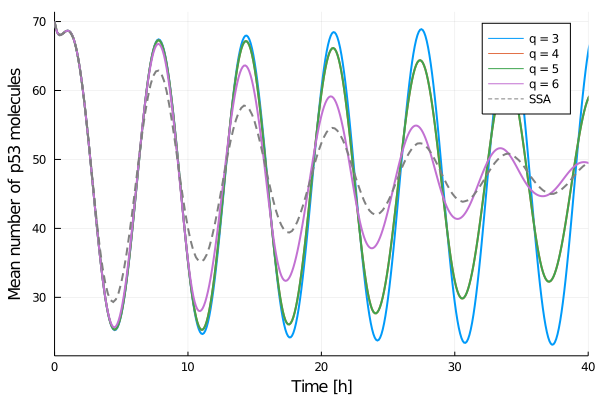

In [17]:
# zoom-in on the initial dampening
plot(plts[1], xlims=(0., 40.))

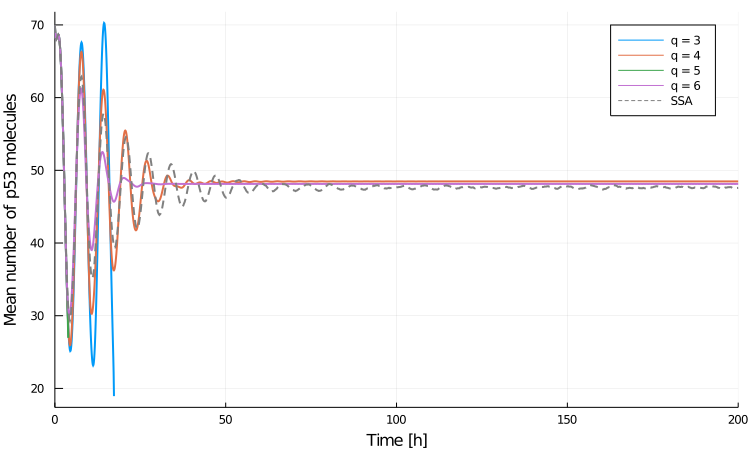

In [18]:
# log-normal closure
plot(plts[2], size=(750, 450), leftmargin=2mm)

In [19]:
savefig("../docs/src/assets/p53-Mdm2_log-normal_2nd_order.svg")

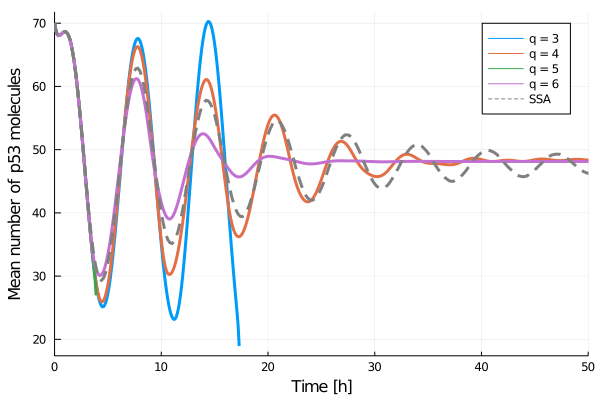

In [20]:
plot(plts[2], xlims=(0., 50.), lw=3)

In [21]:
savefig("../docs/src/assets/p53-Mdm2_log-normal_2nd_order_ZOOM.svg")

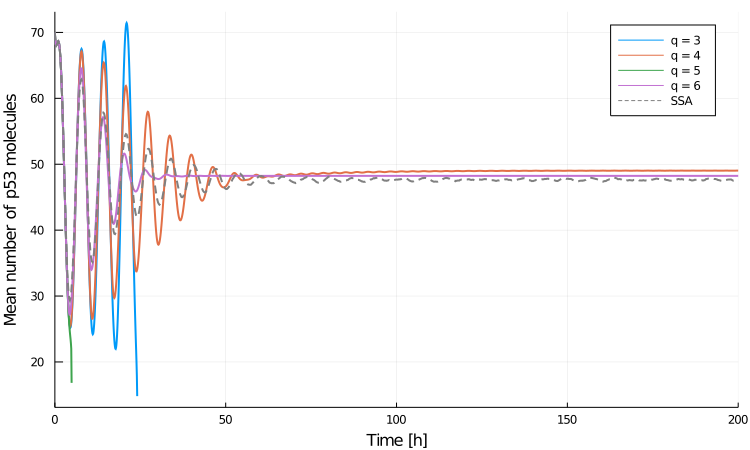

In [22]:
# gamma closure
plot(plts[3], size=(750, 450), leftmargin=2mm)

In [23]:
savefig("../docs/src/assets/p53-Mdm2_gamma_2nd_order.svg")

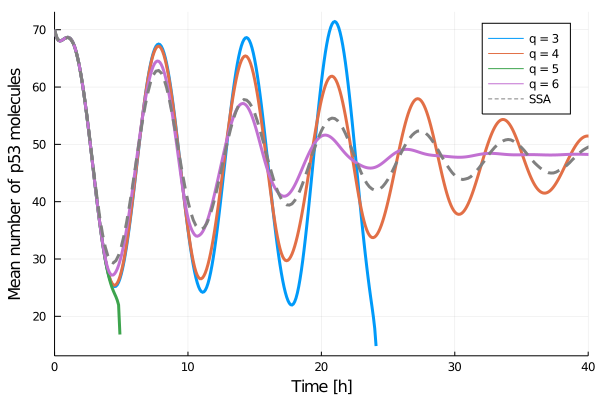

In [24]:
plot(plts[3], xlims=(0., 40.), lw=3)

4
normal
log-normal
gamma
6
normal
log-normal
gamma


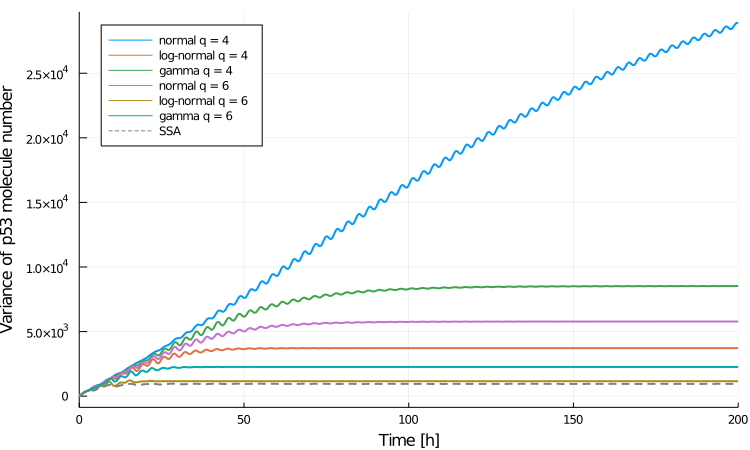

In [25]:
# simply rerunning the same calculations for variance as they are quite fast
plt = plot()

for q in [4,6]
    println(q)
    eqs = generate_central_moment_eqs(rn, 2, q, combinatoric_ratelaw=false)
    for closure in closures
        println(closure)
        closed_eqs = moment_closure(eqs, closure)

        u₀map = deterministic_IC(u₀, closed_eqs)
        oprob = ODEProblem(closed_eqs, u₀map, tspan, p)
        sol = solve(oprob, Tsit5(), saveat=0.1)

        # index of M₂₀₀ can be checked with `u₀map` or `closed_eqs.odes.states`
        plt = plot!(plt, sol, vars=(0, 4), lw=2, label  = closure*" q = "*string(q))
    end
end

plt = plot!(plt, xlabel = "Time [h]", ylabel = "Variance of p53 molecule number", legend=:topleft)
plt = plot!(plt, means_SSA.t, vars_SSA[1,:], lw=2, linestyle=:dash, label = "SSA", color="gray")
plot(plt, size=(750, 450))

In [26]:
savefig("../docs/src/assets/p53-Mdm2_variances_2nd_order.svg")

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\asukys\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:351


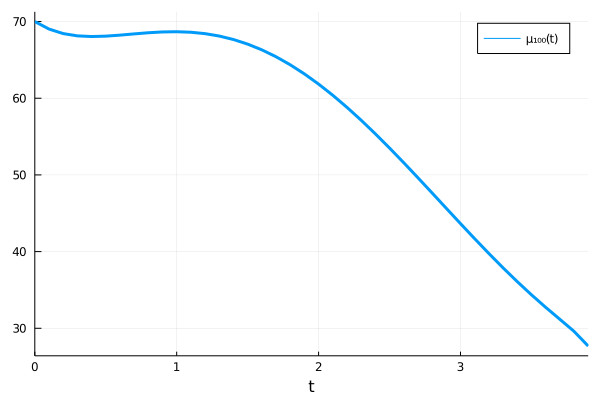

In [27]:
# checking whether third-order moment expansion with odd q values is unstable (answer: yes it is)
eqs = generate_central_moment_eqs(rn, 3, 5, combinatoric_ratelaw=false)
closed_eqs = moment_closure(eqs, "log-normal")

u₀map = deterministic_IC(u₀, closed_eqs) 
oprob = ODEProblem(closed_eqs, u₀map, tspan, p)

sol = solve(oprob, Tsit5(), saveat=0.1)
plot(sol, vars=(0, 1), lw=3)

zero


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\asukys\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:331


normal
log-normal
gamma
zero


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\asukys\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:331


normal
log-normal
gamma


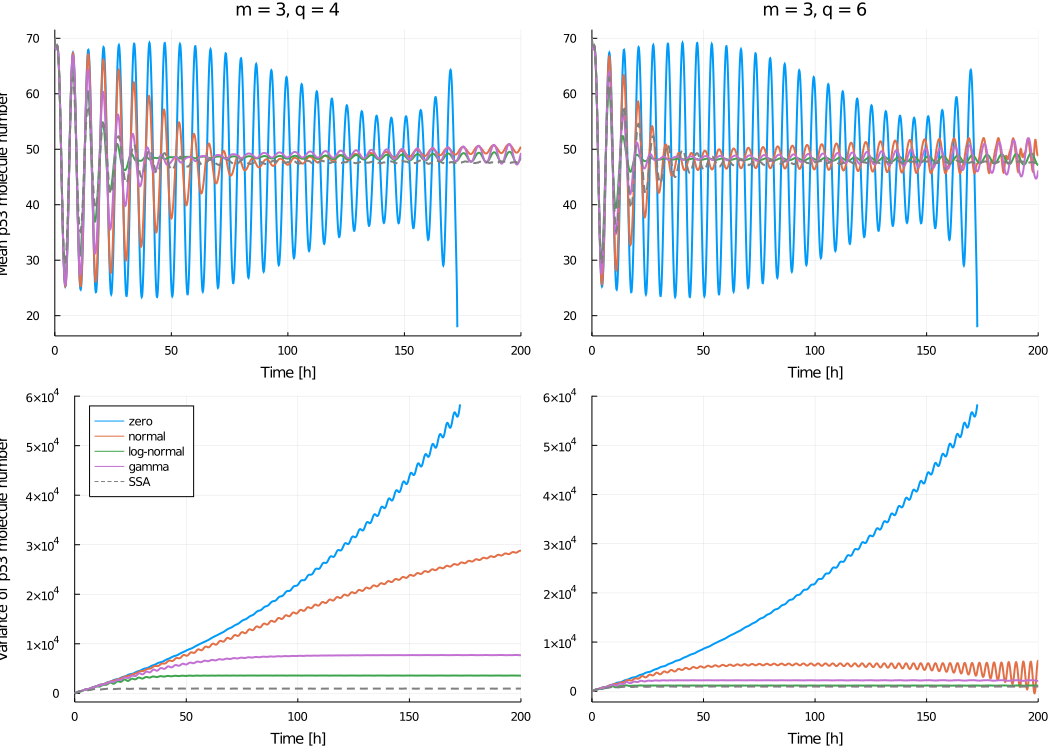

In [28]:
closures = ["zero", "normal", "log-normal", "gamma"]

plt_means = [plot() for i in 1:2]
plt_vars  = [plot() for i in 1:2]

m = 3
q_vals = [4, 6]

for (q, plt_m, plt_v) in zip(q_vals, plt_means, plt_vars)

    eqs = generate_central_moment_eqs(rn, m, q, combinatoric_ratelaw=false)
    for closure in closures
        println(closure)
        closed_eqs = moment_closure(eqs, closure)

        u₀map = deterministic_IC(u₀, closed_eqs)
        oprob = ODEProblem(closed_eqs, u₀map, tspan, p)

        sol = solve(oprob, Tsit5(), saveat=0.1)
        plt_m = plot!(plt_m, sol, vars=(0, 1), label = closure)    
        plt_v = plot!(plt_v, sol, vars=(0, 4), label = closure)

    end

    plt_m = plot!(plt_m, means_SSA.t, means_SSA[1,:], title="m = "*string(m)*", q = "*string(q),
                  linestyle=:dash, label = "SSA", color="gray", legend=false)

    plt_v = plot!(plt_v, vars_SSA.t, vars_SSA[1,:], linestyle=:dash, label = "SSA", color="gray", legend=false)

end

plt_means[1] = plot(plt_means[1], ylabel = "Mean p53 molecule number")
plt_vars[1] = plot(plt_vars[1], ylabel = "Variance of p53 molecule number", legend=:topleft)
plot(plt_means..., plt_vars..., size=(1250, 750), lw=1.5, xlabel="Time [h]",
     guidefontsize=10, titlefontsize=12, legendfontsize=8, leftmargin=4mm, bottommargin=2mm)

In [30]:
savefig("../docs/src/assets/p53-Mdm2_3rd_order_expansion.svg")

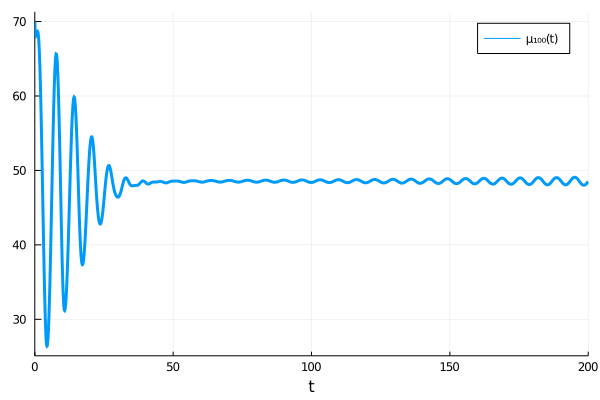

In [31]:
# checking the trajectories using the QNDF (or ode15s) solve which is the default MEANS solver
# slight differences remaning between the trajectory obtained here and the one obtained using MEANS
# indicate that the difference lies in the implementation (inclusion of higher-order moment 
# information in the closure functions)

eqs = generate_central_moment_eqs(rn, 3, 4, combinatoric_ratelaw=false)
closed_eqs = moment_closure(eqs, "log-normal")

u₀map = deterministic_IC(u₀, closed_eqs) 
oprob = ODEProblem(closed_eqs, u₀map, tspan, p)

sol = solve(oprob, QNDF(), saveat=0.1)
plot(sol, vars=(0, 1), lw=3)

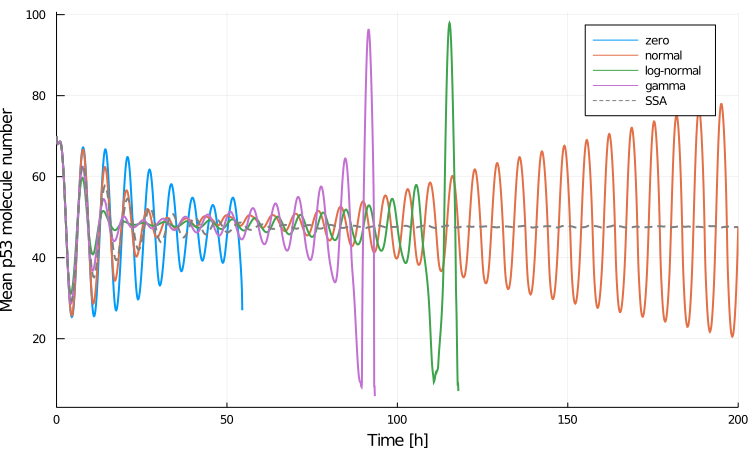

In [58]:
plt = plot()
closures = ["zero", "normal", "log-normal", "gamma"]

eqs = generate_central_moment_eqs(rn, 5, 6, combinatoric_ratelaw=false)
# faster to store than recompute in case we want to try different solvers/params
oprobs = Dict() 

for closure in closures
    println(closure)
    closed_eqs = moment_closure(eqs, closure)

    u₀map = deterministic_IC(u₀, closed_eqs) 
    oprobs[closure] = ODEProblem(closed_eqs, u₀map, tspan, p)
    sol = solve(oprobs[closure], Tsit5(), saveat=0.1)

    plt = plot!(plt, sol, vars=(0, 1), label = closure)    
end

plt = plot!(plt, xlabel = "Time [h]", ylabel = "Mean p53 molecule number")
plt = plot!(plt, means_SSA.t, means_SSA[1, :], linestyle=:dash, label = "SSA", color="gray")
plot(plt, size=(750, 450), lw=2)

In [59]:
savefig("../docs/src/assets/p53-Mdm2_5th_order_expansion.svg")

In [ ]:
# obtain both means and variances for fifth order moment expansion
#=
plt_m = plot()
plt_v = plot()

closures = ["zero", "normal", "log-normal", "gamma"]

eqs = generate_central_moment_eqs(rn, 5, 6, combinatoric_ratelaw=false)
# faster to store than recompute in case we want to try different solvers/params
oprobs = Dict() 

for closure in closures
    println(closure)
    closed_eqs = moment_closure(eqs, closure)

    u₀map = deterministic_IC(u₀, closed_eqs) 
    oprobs[closure] = ODEProblem(closed_eqs, u₀map, tspan, p)
    sol = solve(oprobs[closure], Tsit5(), saveat=0.1)

    plt_m = plot!(plt_m, sol, vars=(0, 1), label = closure)    
    plt_v = plot!(plt_v, sol, vars=(0, 4), label = closure)
end

plt_m = plot!(plt_m, xlabel = "Time [h]", ylabel = "Mean p53 molecule number", legend=false)
plt_m = plot!(plt_m, means_SSA.t, means_SSA[1, :], linestyle=:dash, label = "SSA", color="gray")

plt_v = plot!(plt_v, xlabel = "Time [h]", ylabel = "Variance of p53 molecule number", legend=:bottomleft)
plt_v = plot!(plt_v, vars_SSA.t, vars_SSA[1, :], linestyle=:dash, label = "SSA", color="gray")
plot(plt_m, plt_v, size=(1200, 400), lw=2, leftmargin=5mm, bottommargin=5mm, guidefontsize=10, legendfontsize=10)
=#

In [ ]:
#=
plt_m = plot(xlabel = "Time [h]", ylabel = "Mean p53 molecule number")
for closure in closures
    oprob_long = remake(oprobs[closure], tspan=(0., 150.))
    sol = solve(oprob_long, Tsit5(), saveat=0.1)
    plt_m = plot!(plt_m, sol, vars=(0,1), label=closure)
end
plot(plt_m, lw=2)
=#